In [61]:
import nonlinear_benchmarks
import jax
import jax.numpy as jnp
import orbax
import orbax.checkpoint
from pathlib import Path
from jaxid.models import StateUpdateAndOptput, MLP
import jaxid.metrics
import matplotlib.pyplot as plt
from argparse import Namespace

In [62]:
ckpt = orbax.checkpoint.PyTreeCheckpointer().restore(Path(".").resolve()/"models" / "model1")
cfg = ckpt["cfg"]
cfg = Namespace(**cfg)

In [63]:
f_xu = MLP([64, 32, cfg.nx])
g_x = MLP([64, 32, cfg.ny])
fg = StateUpdateAndOptput(f_xu, g_x)

In [64]:
# Load test data
train_val, test = nonlinear_benchmarks.WienerHammerBenchMark()
u_test, y_test = test
u_test = u_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [65]:
# Make scalers (would be better to save them with the checkpoint...)
u_train, y_train = train_val   
u_train = u_train.reshape(-1, cfg.nu)
y_train = y_train.reshape(-1, cfg.ny)

from sklearn.preprocessing import StandardScaler
# Rescale data
scaler_u = StandardScaler()
scaler_u.fit(u_train)

scaler_y = StandardScaler()
scaler_y.fit(y_train);

In [66]:

# Load scalers
params = ckpt["params"]
#scaler_u = ckpt["scaler_u"]
#scaler_y = ckpt["scaler_y"]

In [67]:
# Define loss
def simulate(params, x0, u_seq):
    fg_func = lambda x, u: fg.apply(params, x, u)
    return jax.lax.scan(fg_func, x0, u_seq)

In [68]:
u_test = scaler_u.transform(u_test)
x0 = jnp.zeros(cfg.nx)
_, y_test_hat = simulate(params, x0, u_test)
y_test_hat = scaler_y.inverse_transform(y_test_hat)


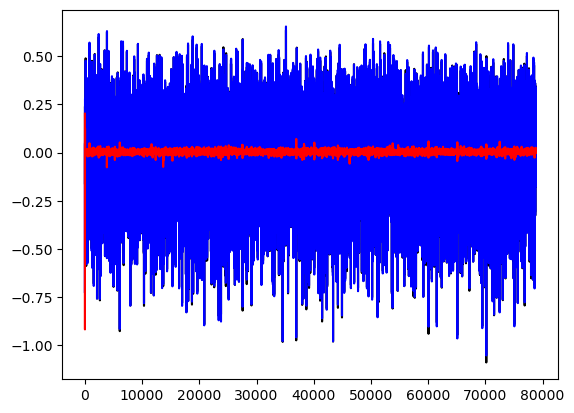

In [69]:

plt.plot(y_test, "k")
plt.plot(y_test_hat, "b")
plt.plot(y_test_hat - y_test, "r")
plt.show()

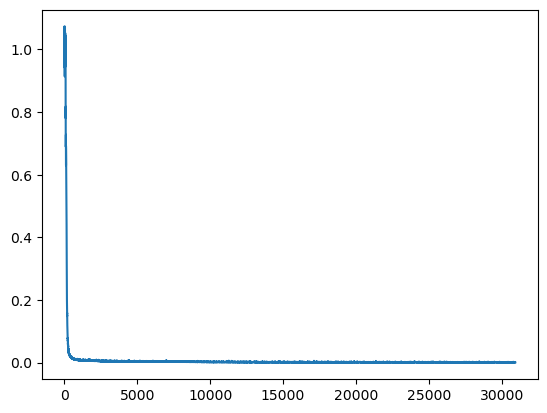

In [70]:
plt.plot(ckpt["LOSS"])

In [71]:
fit = jaxid.metrics.fit_index(y_test, y_test_hat)[0]
rmse = jaxid.metrics.rmse(y_test, y_test_hat)[0] * 1000
nrmse = jaxid.metrics.nrmse(y_test, y_test_hat)[0]


print(f"{fit=} \n{rmse=} mV \n{nrmse=}")

fit=94.86659010582635 
rmse=12.518193540380892 mV 
nrmse=0.05133409894173645
